# SHAP for Hyper-Rectangle Base Models

In [1]:
import numpy as np
from matplotlib import pyplot as plt

## Prepare Data

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [3]:
mc = fetch_openml('machine_cpu', parser='auto')
mc_X = np.asarray(mc['data'])
mc_y = np.asarray(mc['target'])
mc_feature_names = mc['feature_names']
mc_X_train, mc_X_test, mc_y_train, mc_y_test = train_test_split(
    np.asarray(mc_X), np.asarray(mc_y),
    random_state=12345
)

/Users/andruekonst/miniforge3/envs/HRBM/lib/python3.10/site-packages/sklearn/datasets/_openml.py:301: UserWarning: Multiple active versions of the dataset matching the name machine_cpu exist. Versions may be fundamentally different, returning version 1.
  warn(


## Build a Model

In [4]:
from hrbm.wrappers.scaler import ScalerWrapper
from hrbm.boosting.corner import CornerBoosting

from sklearn.metrics import r2_score

In [5]:
mc_ens = ScalerWrapper(
    CornerBoosting(
        learning_rate=1.0,
        need_rsm=True,
        rsm_size=5,
        val_size=0.5,
        hold_validation_set=False,
        enable_validation=False,
        reg_type='value',
        l1_reg=0.0,
        l2_reg='auto',
        l1_reg_min=0.0,
        l2_reg_min=0.01,
        n_estimators=10000,
        reg_beta=0.01,
        random_state=12345,
    )
)

mc_ens.fit(mc_X_train, mc_y_train)

ScalerWrapper(model=CornerBoosting(enable_validation=False,
                                   hold_validation_set=False, l2_reg='auto',
                                   l2_reg_min=0.01, learning_rate=1.0,
                                   n_estimators=6164, need_rsm=True,
                                   random_state=12345, reg_beta=0.01,
                                   rsm_size=5))

In [6]:
print("R^2 on test:", r2_score(mc_y_test, mc_ens.predict(mc_X_test)))

R^2 on test: 0.9129935220881181


In [7]:
explain_points = mc_X_test[:10]

## Explanation

### Model-Based

In [8]:
from hrbm.shap.model_based import ModelBasedEnsembleSHAP

In [9]:
model_explainer = ModelBasedEnsembleSHAP(mc_ens.model)

In [10]:
model_values, model_bias = model_explainer(explain_points)

In [11]:
np.allclose(model_bias + model_values.sum(axis=1), mc_ens.model.predict(explain_points))

True

In [12]:
all_train_model_values, _ = model_explainer(mc_X_train)

In [13]:
corrected_model_values = model_values - all_train_model_values.mean(axis=0)[np.newaxis]

In [38]:
corrected_all_tmv = all_train_model_values - all_train_model_values.mean(axis=0)[np.newaxis] 

### Data-Based

In [14]:
from hrbm.shap.data_based import DataBasedEnsembleSHAP

In [16]:
data_explainer = DataBasedEnsembleSHAP(mc_ens.model, mc_X_train)

In [17]:
data_values, data_bias = data_explainer(explain_points)

In [18]:
np.allclose(data_bias + data_values.sum(axis=1), mc_ens.model.predict(explain_points))

True

In [19]:
all_train_data_values, _ = data_explainer(mc_X_train)

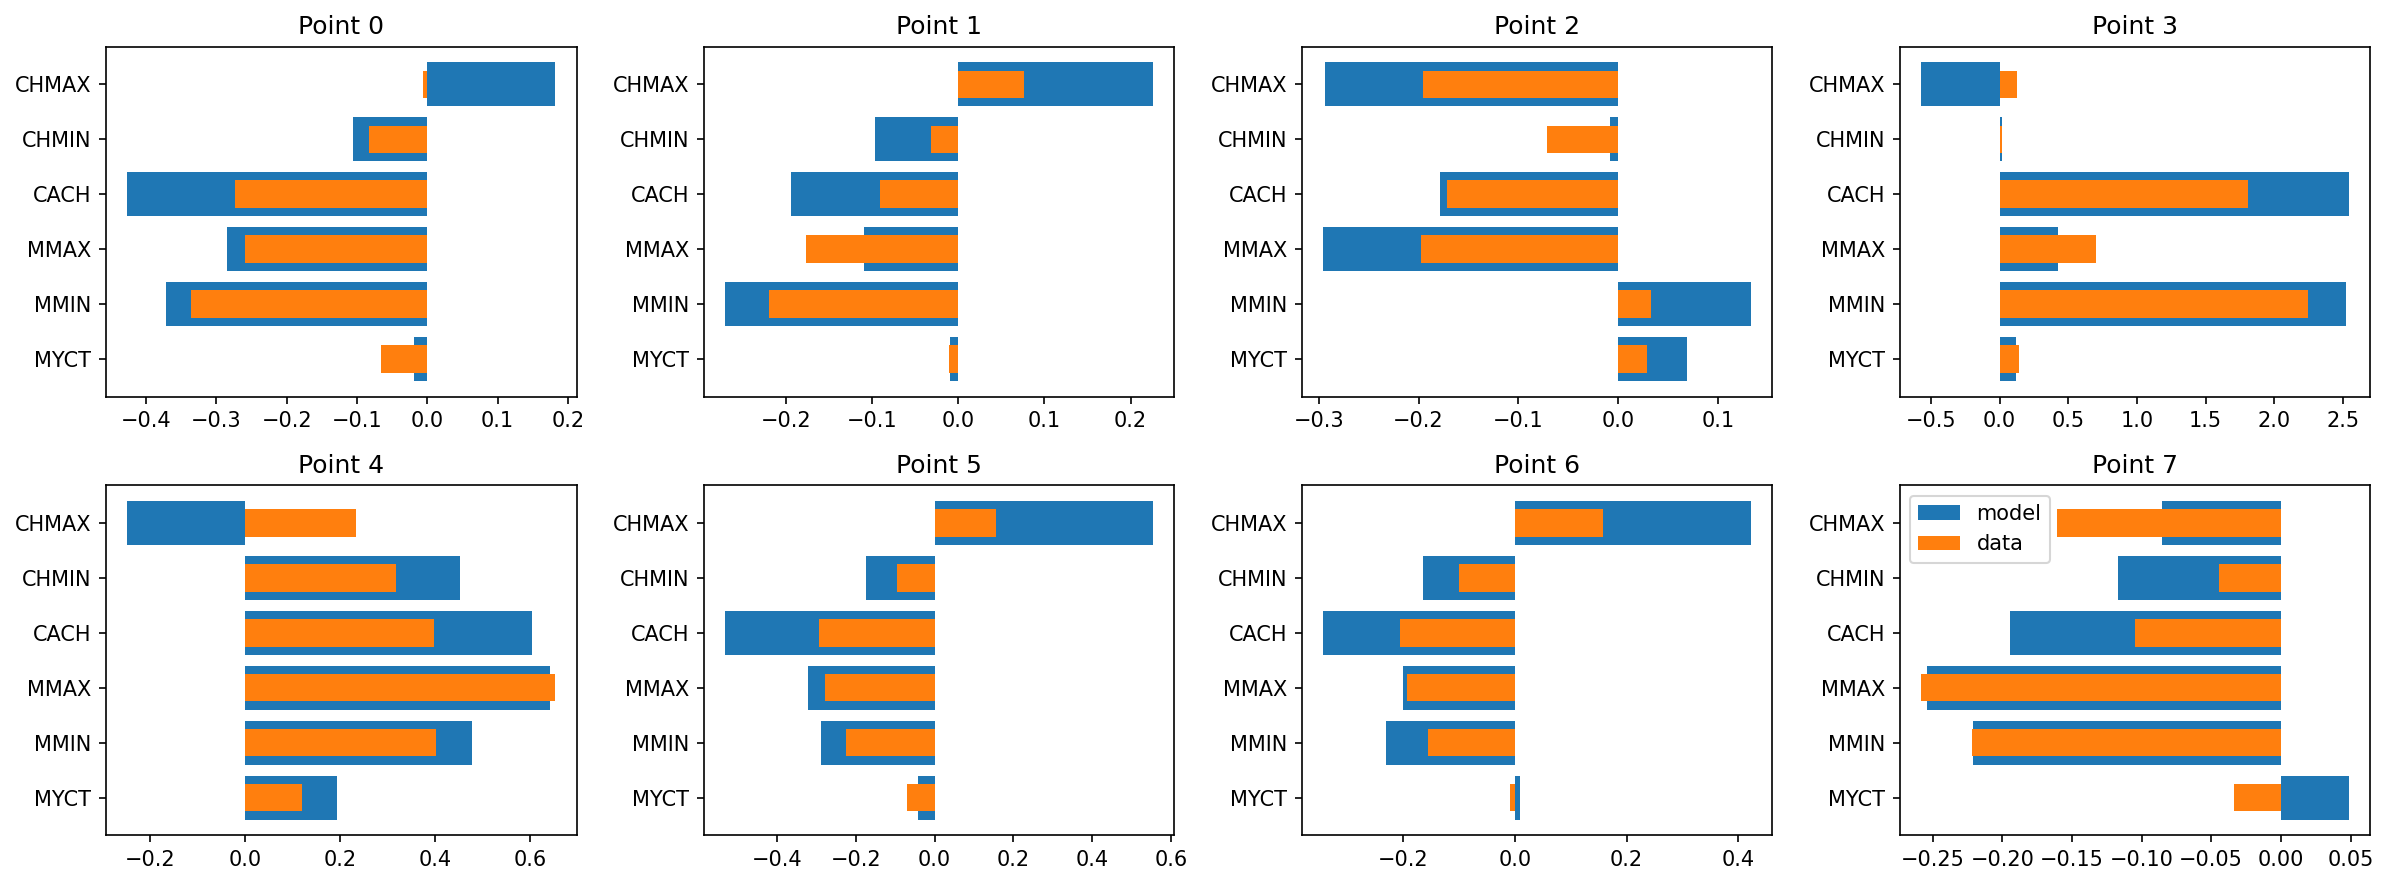

In [37]:
fig, ax = plt.subplots(2, 4, dpi=150, figsize=(16, 6))
for i, a in enumerate(ax.ravel()):
    a.barh(mc_feature_names, corrected_model_values[i], label='model')
    a.barh(mc_feature_names, data_values[i], height=0.5, label='data')
    a.set_title(f'Point {i}')

plt.legend()
plt.tight_layout()

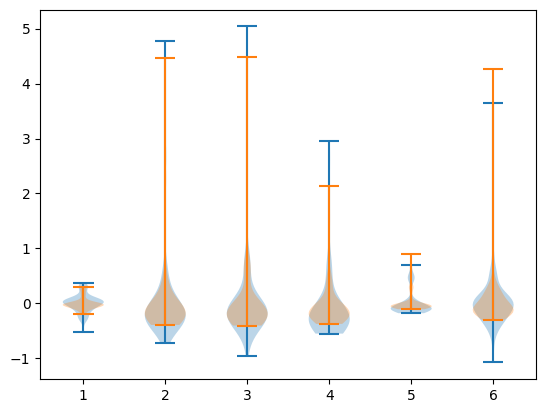

In [47]:
plt.violinplot(corrected_all_tmv);
plt.violinplot(all_train_data_values);